In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('abalone.csv')
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
#rename output variable
df.rename(columns={"Sex":"sex", "Length":"length", "Diameter":"diameter",
                   "Height":"height", "Whole weight":"whole_weight",
                   "Shucked weight":"shucked_weight", "Viscera weight":"viscera_weight",
                   "Shell weight":"shell_weight", "Rings":"rings"}, inplace = True)

In [6]:
df.shape

(4177, 9)

In [7]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


ANALYSIS

As we can see, under height column, the minimum value is 0. (Not possible)
We need to remove that, may be that height is not calculated for that particular sample

In [8]:
df[df['height'] == 0]  #need to drop these rows.

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [9]:
df.drop(index=[1257,3996], inplace = True)
df.shape

(4175, 9)

#### Dependent Variable

In [10]:
df['age'] = df['rings']+1.5 #AS per the problem statement
df.drop('rings', axis = 1, inplace = True)
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


#### Explortory Data Analysis

Boxen Plot: Age Vs Sex

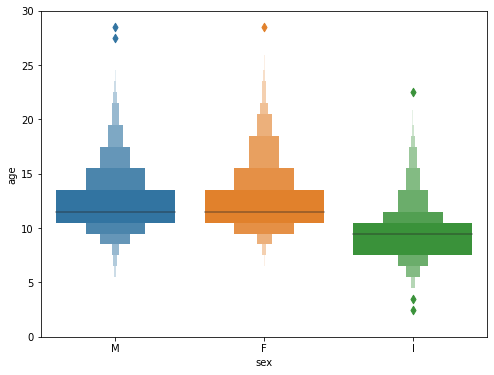

In [11]:
#categorical features
temp = pd.concat([df['age'], df['sex']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxenplot(x='sex', y="age", data=df)
fig.axis(ymin=0, ymax=30);

ANALYSIS

There is no difference in age of rings for male and female (8-19). But in infants, it lies between (5-10)

###### Count Plot

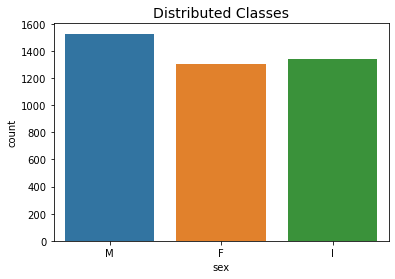

In [13]:
sns.countplot('sex', data=df)
plt.title('Distributed Classes', fontsize=14)
plt.show()

Histograms: Understanding the Distribution of the Numerical Features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB2B0FA640>,
      dtype=object)

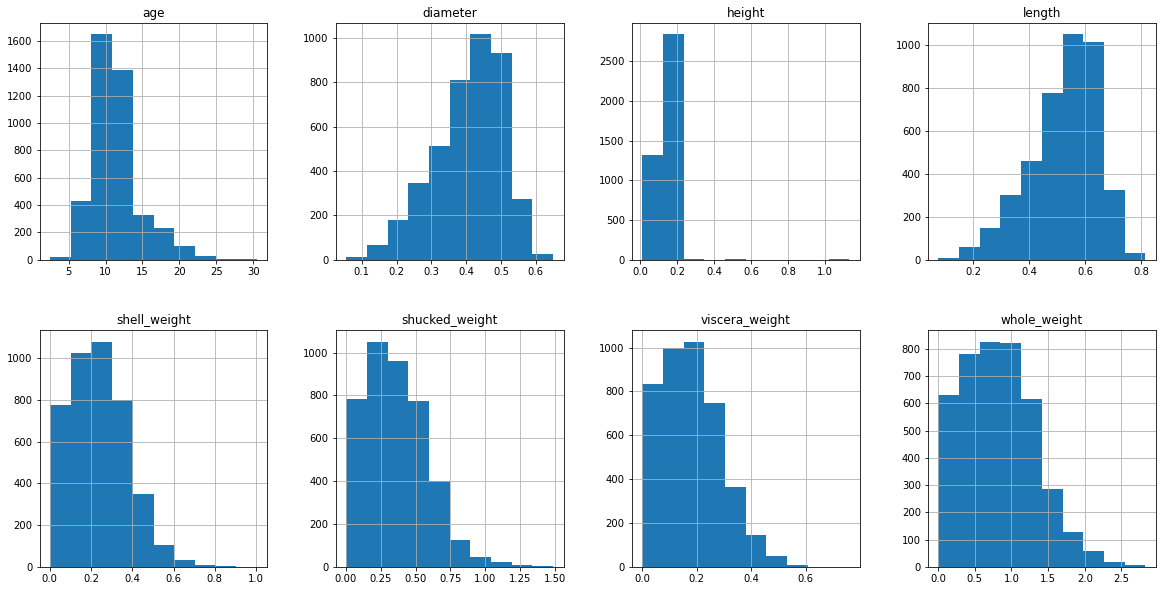

In [14]:
df.hist(figsize = (20,10), layout = (2,4))

ANALYSIS

1.Skewness of the height is too high. (need to normalise later...)


2.Need to check skewness for all varibles

##### Skewness of the Variables

In [17]:
df.skew().sort_values(ascending = False)

height            3.166364
age               1.113754
shucked_weight    0.718735
shell_weight      0.621081
viscera_weight    0.591455
whole_weight      0.530549
diameter         -0.610182
length           -0.640993
dtype: float64

ANALYSIS:

Skewness is close to 0 for Normal distribution curve.

Height has the highest skewness of 3.17.

May be there are outliers in height, we need to check that and remove them before modeling.

Will check the coorelation with the dependent variable (Rings)

Will use IQR algorithm to remove outliers.

##### Coorelation Plot

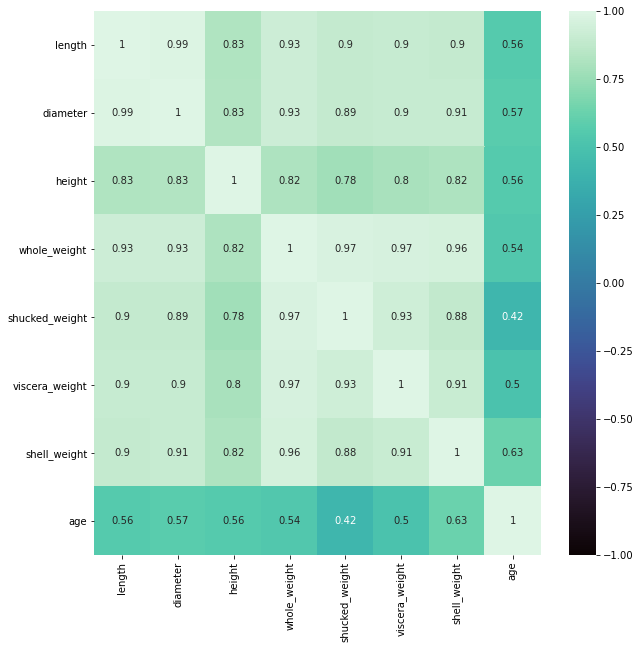

In [18]:
corr = df.corr()
plt.figure(figsize = (10,10))
ax = sns.heatmap(corr, vmin = -1, center = 0, annot = True, cmap = 'mako')

ANALYSIS

No Negative correlation found

High coorelation between Length & Diameter

High corelation between shucked weight, viscera weight Vs Whole_weight & Shell weight vs Whole_weight

In [21]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
columns_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)] #highly correlated variables to be removed.

print("Columns to drop:\n", columns_to_drop)

Columns to drop:
 ['diameter', 'shucked_weight', 'viscera_weight', 'shell_weight']


ANALYSIS

We will remove the above columns, before proceeding any further.


#### DROP COLUMNS

In [23]:
df.drop(columns_to_drop, axis=1, inplace = True)

In [24]:
df.head()

,sex,length,height,whole_weight,age
0,M,0.455,0.095,0.5140,16.5
1,M,0.350,0.090,0.2255,8.5
2,F,0.530,0.135,0.6770,10.5
3,M,0.440,0.125,0.5160,11.5
4,I,0.330,0.080,0.2050,8.5


#### Variance Inflation Factor

In [25]:
#calculating VIF
def vif_arr(df1):
    vif = pd.DataFrame()
    df1 = sma.add_constant(df1)
    vif["Features"] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    return(vif)

In [26]:
temp = df.drop('sex', axis = 1) #i.e. categorical
vif_arr(temp).sort_values(by = 'Features', ascending = False)

,Features,VIF
3,whole_weight,7.425114
1,length,7.833655
2,height,3.532659
0,const,62.359271
4,age,1.515261


ANALYSIS

Whole weight and length have slighter higher VIF. We will consider this as of now.

Box Plots

Text(0.5, 1.0, 'height vs sex')

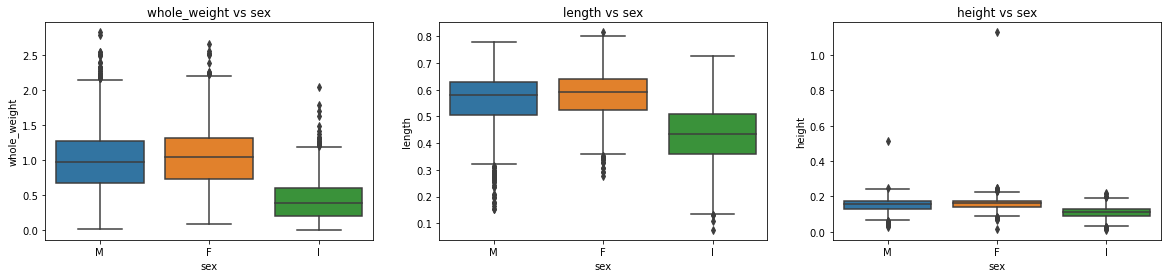

In [28]:
f, axes = plt.subplots(ncols = 3, figsize = (20,4))

sns.boxplot(x = 'sex', y = 'whole_weight', data = df, ax = axes[0])
axes[0].set_title('whole_weight vs sex')

sns.boxplot(x = 'sex', y = 'length', data = df, ax = axes[1])
axes[1].set_title('length vs sex')

sns.boxplot(x = 'sex', y = 'height', data = df, ax = axes[2])
axes[2].set_title('height vs sex')

Normalise Height

By doing Square root transofrmation

In [30]:
df['height'] = np.sqrt(df['height'])

##### Checking skewness again

In [31]:
#checking skewness again
df.skew().sort_values(ascending = False)

age             1.113754
whole_weight    0.530549
height         -0.176012
length         -0.640993
dtype: float64

ANALYSIS

All independent varibles values are close to zero. So, they are now close to gaussian distribution. :)

##### Histograms: Distribution of the Numerical Features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB2C307340>,
      dtype=object)

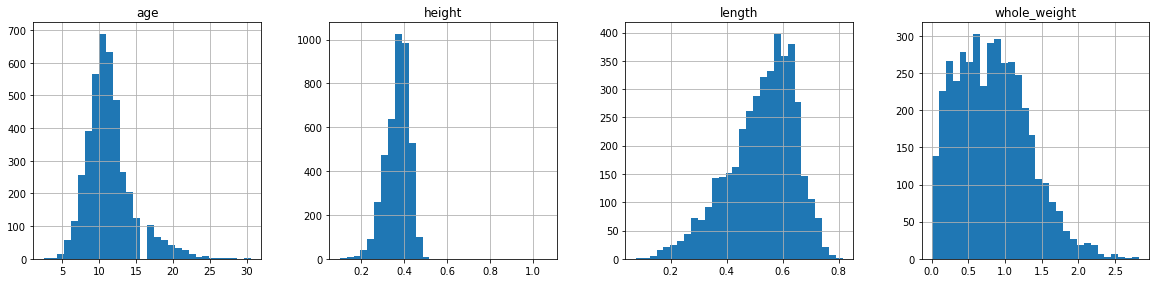

In [33]:
df.hist(figsize = (20,10), layout = (2,4), bins = 30)

ANALYSIS

As we can see, previously Height was highly skewed. But now, its normally distributed

All skewed data values are close to 0.

#### Model Creation

In [36]:
df.head()

,sex,length,height,whole_weight,age
0,M,0.455,0.308221,0.5140,16.5
1,M,0.350,0.300000,0.2255,8.5
2,F,0.530,0.367423,0.6770,10.5
3,M,0.440,0.353553,0.5160,11.5
4,I,0.330,0.282843,0.2050,8.5


In [37]:
Age = []
for i in df["whole_weight"]:
    if i < 0.6:
        Age.append(1)
    elif i > 0.6 and i < 1.0 :
        Age.append(2)
    else:
        Age.append(3)
df["age"] = Age
#df_1.drop("age" , axis =1,inplace=True)
df.head()

,sex,length,height,whole_weight,age
0,M,0.455,0.308221,0.5140,1
1,M,0.350,0.300000,0.2255,1
2,F,0.530,0.367423,0.6770,2
3,M,0.440,0.353553,0.5160,1
4,I,0.330,0.282843,0.2050,1


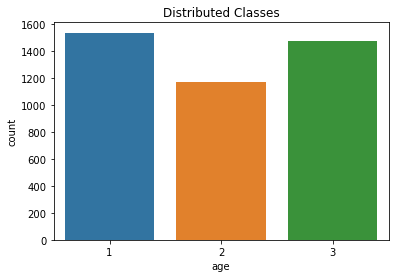

In [38]:
sns.countplot('age', data=df)
plt.title('Distributed Classes')
plt.show()

In [39]:
new_df = pd.get_dummies(df, columns = ['sex'], prefix_sep='_', drop_first = True)
new_df['age'].value_counts()

1    1534
3    1473
2    1168
Name: age, dtype: int64

###### VIF For All Independent Features CombinedVIF For All Independent Features Combined

In [40]:
#NEW VIF
vif_arr(new_df).sort_values(by = 'Features', ascending = False)

,Features,VIF
3,whole_weight,9.799019
6,sex_M,1.384868
5,sex_I,1.983488
1,length,9.680103
2,height,4.979747
0,const,128.016288
4,age,5.326806


ANALYSIS

Taking Sqrt Transoformation for Length column.

In [42]:
new_df['length'] = np.sqrt(new_df['length'])
vif_arr(new_df).sort_values(by = 'Features', ascending = False)

,Features,VIF
3,whole_weight,8.556129
6,sex_M,1.384512
5,sex_I,1.984036
1,length,7.495609
2,height,5.302027
0,const,249.609951
4,age,5.264169


##### Independent & Dependent Features

In [43]:
X = new_df.drop('age', axis = 1)
y = new_df['age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)

X_train = X_train_std.values
X_test = X_test_std.values
y_train = y_train.values
y_test = y_test.values

classifiers = {"LogisiticRegression": LogisticRegression(),
               "KNearest": KNeighborsClassifier(),
               "Support Vector Classifier": SVC(),
               "DecisionTreeClassifier": DecisionTreeClassifier()}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 98.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 97.0 % accuracy score
Classifiers:  SVC Has a training score of 97.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 100.0 % accuracy score


###### We will choose Logistic Regression for further analysis

In [44]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_log = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log.fit(X_train, y_train)
log_reg = grid_log.best_estimator_
print('Best Estimators: ', log_reg)

Best Estimators:  LogisticRegression(C=1000, solver='newton-cg')


In [45]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5) #We will use best parameters for modeling
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  99.73%


In [46]:
model = LogisticRegression(C=1000, solver='newton-cg')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       305
           2       0.99      0.98      0.99       238
           3       1.00      1.00      1.00       292

    accuracy                           0.99       835
   macro avg       0.99      0.99      0.99       835
weighted avg       0.99      0.99      0.99       835

[[303   2   0]
 [  3 234   1]
 [  0   0 292]]
